# NLP analysis of movie plots: building classic models

With clean data we can start fitting models and comparing their performance.

## 0. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

#removing warnings
import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#building models
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report 
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor

## 1. Loading data

Next step in our analysis is preprocessing data. Let's load scraped data from csv file

In [2]:
with open('data/X.p', 'rb') as f:
    X = pickle.load(f)

with open('data/y.p', 'rb') as f:
    y = pickle.load(f)

## 2. Splitting data into train and test samples

We only need 2 columns from our data - plot and target value. 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1234, shuffle = True)

print('Train sample size: '+str(len(y_train)))
print('Test sample size: '+str(len(y_test)))

Train sample size: 12168
Test sample size: 4057


In [4]:
vectorizer = CountVectorizer(stop_words = 'english', ngram_range = (2,2), min_df = 30, binary=True)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
len(vectorizer.get_feature_names_out())

668

## 3. Linear Regression

After cleaning the text we can split the data into train and test. No need for validation set as we have small sample. We will use crossvalidation.

Let's vectorize text data so we can build models. As we do not care how often the word ir repeated in the same movie plot, we are using binary count vectorizer. So that the regression does not overfit, the remove frequent words and too rare words.

In [5]:
def get_metrics(y_test, y_predicted):  
    mse = (y_predicted-y_test)**2
    mae = abs(y_predicted-y_test)
    return np.mean(mse), np.mean(mae)

In [6]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)
y_train_pred = lin_reg.predict(X_train)
print(get_metrics(y_train, y_train_pred))

(1.1748222529677246, 0.8266548277763753)


In [7]:
y_test_pred = lin_reg.predict(X_test)
print(get_metrics(y_test, y_test_pred))

(1.26946346355194, 0.8689729060952618)


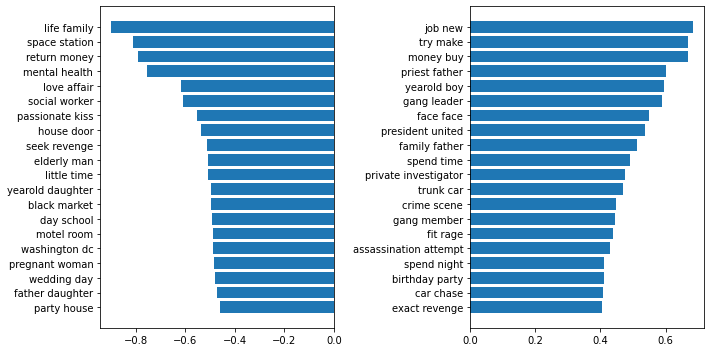

In [12]:
coefficients = pd.DataFrame({'feat_name':vectorizer.vocabulary_.keys(),'coefs':lin_reg.coef_})
bottom = coefficients.sort_values(by = 'coefs', ascending = False).tail(20).set_index('feat_name')
top = coefficients.sort_values(by = 'coefs').tail(20).set_index('feat_name')

fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].barh(bottom.index, bottom['coefs'])
axs[1].barh(top.index, top['coefs'])

fig.tight_layout()
plt.show()

In [9]:
xgbr = XGBRegressor(objective="reg:squarederror", random_state=1234)
xgbr.fit(X_train, y_train)
y_train_pred = xgbr.predict(X_train)
print(get_metrics(y_train, y_train_pred))

(0.9939737016949631, 0.7611194289412503)


In [10]:
y_test_pred = xgbr.predict(X_test)
print(get_metrics(y_test, y_test_pred))

(1.25462405561874, 0.8608439460069867)


## 4. Classification

In [13]:
y_bin = [0 if x >= 6 else 1 for x in y]
sum(y_bin)

5132

We managed to achieve nice results using linear regression. But it might be unnecessary to try predicting the rating of the movie. We only need to predict if the movie is highly rated or not.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, random_state = 1234, shuffle = True, stratify = y_bin)

print('Train sample size: '+str(len(y_train)))
print('Test sample size: '+str(len(y_test)))

Train sample size: 12168
Test sample size: 4057


In [15]:
vectorizer = CountVectorizer(ngram_range = (1,1), max_df = 3000, min_df = 50, binary=True)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
len(vectorizer.get_feature_names_out())

3913

Let's define the metrics we use for model optimization. We use standard metrics like accuracy, precision, recall and f1-score.

In [16]:
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [17]:
def fit_class_model(model, param_grid):
    clf = GridSearchCV(model, param_grid, n_jobs=-1, verbose = 3, scoring = 'f1')
    clf.fit(X_train, y_train)
    print("Best parameter: "+str(clf.best_params_))
    
    y_train_pred = clf.predict(X_train)
    accuracy, precision, recall, f1 = get_metrics(y_train, y_train_pred)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    
    y_test_pred = clf.predict(X_test)
    accuracy, precision, recall, f1 = get_metrics(y_test, y_test_pred)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))
    
    fig, axs = plt.subplots(1,2, figsize = (10,4))
    cf_matrix = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', ax = axs[0])
    cf_matrix = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues', ax = axs[1])
    plt.show()


### 4.2 Logistic regression

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameter: {'C': 0.01}
accuracy = 0.753, precision = 0.786, recall = 0.753, f1 = 0.760
accuracy = 0.668, precision = 0.706, recall = 0.668, f1 = 0.678


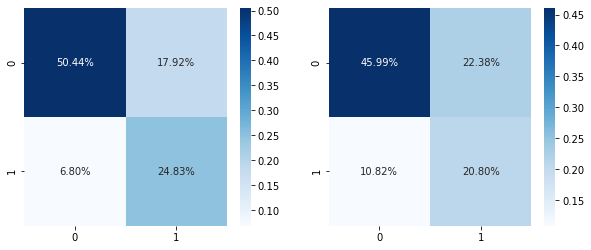

In [18]:
log_reg = LogisticRegression(class_weight = 'balanced')

param_grid = {
    "C": [0.001, 0.01, 0.1, 1]
}
fit_class_model(log_reg, param_grid)

### 4.3 Random forest classifier

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameter: {'max_depth': 500}
accuracy = 0.986, precision = 0.986, recall = 0.986, f1 = 0.986
accuracy = 0.706, precision = 0.686, recall = 0.706, f1 = 0.646


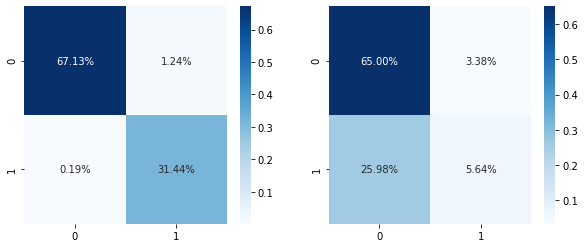

In [20]:
rfc = RandomForestClassifier(n_estimators = 300, class_weight = 'balanced')

param_grid = {
    "max_depth": [500, 1000, 2000]
}
fit_class_model(rfc, param_grid)

### 4.4 XGBoost classifier

In [ ]:
xgb = XGBClassifier(n_estimators = 500, subsample = 0.6)

param_grid = {
    "max_depth": [40, 50, 60]
}
fit_class_model(xgb, param_grid)

### 4.1 Naive Bayes

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameter: {'alpha': 0.001}
accuracy = 0.703, precision = 0.735, recall = 0.703, f1 = 0.712
accuracy = 0.673, precision = 0.705, recall = 0.673, f1 = 0.683


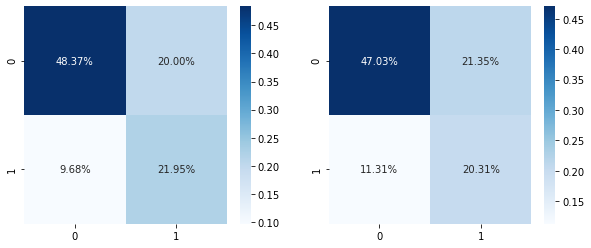

In [21]:
naive_b = BernoulliNB()

param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1]
}

fit_class_model(naive_b, param_grid)